In [12]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib import colors
import threading, queue
import scipy.io


from Tree import Node


In [13]:
#split s means we check all y-values to see if they're above or below the line
# %%
#split s means we check all y-values to see if they're above or below the line
'''
split cost functions
Desc: finds cost of a split
parameters: 
s: split value
c1: mean color left/below split [r,g,b]
c2: mean color right/above split [r,g,b]
'''
def hor_split_cost(s, y_values, vals):
    #get values left 
    left_values = vals[np.nonzero(y_values <= s)]
    right_values = vals[np.nonzero(y_values > s)]
    c1 = np.mean(left_values, axis = 0)
    c2 = np.mean(right_values, axis = 0)
    #print(len(left_values))
    #print(c1)
    left_values -= np.tile(c1, (len(left_values), 1))
    right_values -= np.tile(c2, (len(right_values), 1))
    #print(left_values)
    cost = np.sum(np.square(np.linalg.norm(left_values, axis=1))) + np.sum(np.square(np.linalg.norm(right_values, axis=1)))
    return cost, c1, c2

def vert_split_cost(s, x_values, vals):
    #get values left 
    left_values = vals[np.nonzero(x_values <= s)]
    right_values = vals[np.nonzero(x_values > s)]
    c1 = np.mean(left_values, axis = 0)
    c2 = np.mean(right_values, axis = 0)
    #print(len(left_values))
    #print(c1)
    left_values -= np.tile(c1, (len(left_values), 1))
    right_values -= np.tile(c2, (len(right_values), 1))
    #print(left_values)
    cost = np.sum(np.square(np.linalg.norm(left_values, axis=1))) + np.sum(np.square(np.linalg.norm(right_values, axis=1)))
    return cost, c1, c2

In [14]:
'''
Returns direction & optimal split value
'''
def OptimalSplitRegression(x_data,y_data,vals):
    #pre-sort X & Y values:
    x_sorted = np.sort(x_data)
    y_sorted = np.sort(y_data)

    #print(x_sorted)

    #get split values by summing array with shifted array by 1 to right and taking mean of every entry
    x_splits = 0.5 * (x_sorted[:-1]+np.roll(x_sorted,-1)[:-1])
    y_splits = 0.5 * (y_sorted[:-1]+np.roll(y_sorted,-1)[:-1])
    #print(x_splits, y_splits)
     
    min_cost = float('inf')
    min_c1: np.array
    min_c2: np.array
    min_direction = False
    min_s = 0

    #find min cost split among both x and y splits
    for x_split in x_splits:
        cost, c1, c2 = hor_split_cost(x_split, x_data, vals)
        if(cost < min_cost):
            min_s = x_split
            min_cost = cost
            min_c1 = c1
            min_c2 = c2
            min_direction = True
    for y_split in y_splits:
        cost, c1, c2 = vert_split_cost(x_split, y_data, vals)
        if(cost <= min_cost):
            min_s = y_split
            min_cost = cost
            min_c1 = c1
            min_c2 = c2
            min_direction = False
    return min_s, min_cost, min_c1, min_c2, min_direction

In [15]:

Y = np.array([0.25, 0.1, 0.8])
X = np.array([0.25,0.8,0.6])
V = np.array([[0.1,0.5,0.2],[0.4,0.1,0.3],[0.9,0.2,0.0]])
n = 3

print(X,Y,V)
s, min_cost,min_c1, min_c2, min_direction = OptimalSplitRegression(X,Y,V)
print(s, min_cost)

'''
#get matlab data as nested dictionary
image = scipy.io.loadmat('MysteryImage.mat')

#extract compressed matrix from dictionaries

#columns: y-axis; rows: x-axis; vals: [r,g,b]
Y = image['cols']
X = image['rows']
V = image['vals']

# number of pixels
n = np.shape(X)[0]
'''

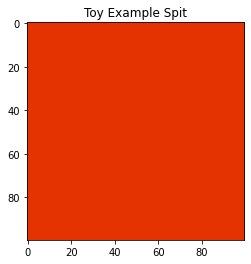

In [16]:
x_dim = 100
y_dim = 100
img = np.zeros((x_dim, y_dim, 3))

if(min_direction):
    #horizontal cut

    #scale it to the integers
    #s *= x_dim
    img[0:x_dim, 0:int(s)] = min_c1
    img[0:x_dim, int(s):y_dim] = min_c2
else:
    #vertical cut
    
    #scale it to the integers
    #s *= y_dim
    img[0:int(s), 0:y_dim] = min_c1
    img[int(s):x_dim, 0:y_dim] = min_c2

plt.imshow(img)
plt.title("Toy Example Spit")
plt.savefig("optimal_split.png")

In [17]:
def write_to_image(img, dir, x_min, x_max, y_min, y_max, s, c1, c2, x_dim, y_dim):
    if(dir):
        #horizontal cut

        #scale it to the integers
        split = s*x_dim
        img[x_min:x_max, y_min:int(split)] = c1
        img[x_min:x_max, int(split):y_max] = c2
    else:
        #vertical cut

        #scale it to the integers
        split  = s* y_dim
        img[x_min:int(split), y_min:y_max] = c1
        img[int(split):x_max, y_min:y_max] = c2

    return img

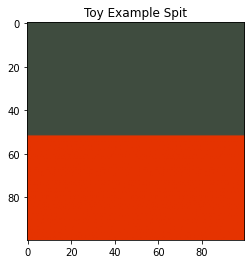

In [18]:
x_dim = 100
y_dim = 100

img = np.zeros((x_dim, y_dim, 3))

plt.imshow(write_to_image(img, min_direction, 0, x_dim, 0, y_dim, s, min_c1, min_c2, x_dim, y_dim))
plt.title("Toy Example Spit")
plt.savefig("optimal_split.png")

In [19]:
#Code for Regression Tree:
MAX_ITTER = 100
x_dim = 2592
y_dim = 1456

#stores leaves to consider
q = queue.Queue()
# X_points, Y_points, x_min, x_max, y_min, y_max, color
init_node = Node(X, Y, V, 0, x_dim, 0, y_dim)

q.put(init_node)
itter = 0
img = np.zeros((x_dim, y_dim, 3))
while itter < MAX_ITTER and q.qsize() > 0:
    curr_node = q.get()
    s, cost, c1, c2, direction = OptimalSplitRegression(curr_node.x_elements,curr_node.y_elements,curr_node.vals)
    
    #write to our image with the current split
    write_to_image(img, direction, curr_node.x_min, curr_node.x_max, curr_node.y_min, curr_node.y_max, s, c1, c2, x_dim, y_dim)
    if(direction):
        y_left = np.nonzero(curr_node.y_elements <= s)
        y_right = np.nonzero(curr_node.y_elements > s)

        left_values = curr_node.vals[y_left]
        right_values = curr_node.vals[y_right]

        #create children node we push to the queue: 
        left_node = Node(curr_node.x_elements, y_left, left_values, curr_node.x_min, curr_node.x_max, curr_node.y_min, s)
        right_node = Node(curr_node.x_elements, y_right, right_values, curr_node.x_min, curr_node.x_max, s, curr_node.y_max)
        q.put(left_node)
        q.put(right_node)
    else:
        x_left = np.nonzero(curr_node.x_elements <= s)
        x_right = np.nonzero(curr_node.x_elements > s)
        
        left_values = curr_node.vals[x_left]
        right_values = curr_node.vals[x_right]
        
        #create children node we push to the queue:
        left_node = Node(x_left, curr_node.y_elements, left_values, curr_node.x_min, s, curr_node.y_min, curr_node.y_max)
        right_node = Node(x_right, curr_node.y_elements, right_values, s, curr_node.x_max, curr_node.y_min, curr_node.y_max)
        q.put(left_node)
        q.put(right_node)

    #keep a queue to store leaves we want to consider:

    #print("w")
#priority queue based on error?

'''
we need top get the indices of the values and then 
'''

ValueError: non-broadcastable output operand with shape (6607,) doesn't match the broadcast shape (6607,6607)